# Reducción de la dimensionalidad sobre datos de motor de inducción
*Ignacio Díaz Blanco, 2023. Universidad de Oviedo*

Ejemplo básico de extracción de características mediante análisis de bandas en frecuencia. En el ejemplo se usan las bandas de 25, 50 y 100 Hz, sobre señales de vibraciones y corrientes del motor. El dataset completo está publicado en 

https://digibuo.uniovi.es/dspace/handle/10651/53461

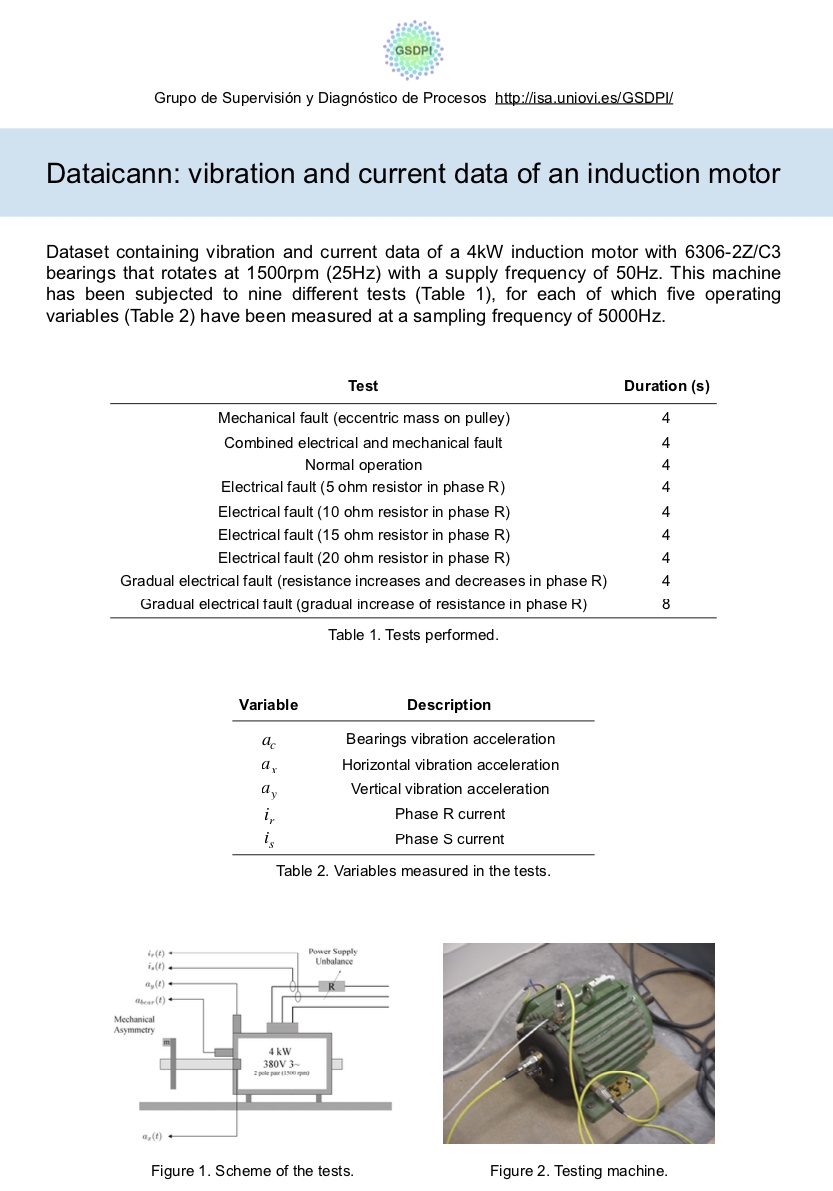

In [1]:
from pylab import *
from scipy.io.matlab import loadmat
import json

%matplotlib inline

### Carga de los datos


In [2]:
# Cargamos los datos, disponibles en formato Matlab (*.mat)
datos = loadmat('../datos/dataicann.mat')

# La frecuencia de muestreo son 5000 Hz (este dato normalmente lo tienen que dar)
fm = 5000.
tm = 1/fm


for k in range(9):
    if k==0:
        p = datos['z'][0][k].T;
    else:
        p = hstack((p,datos['z'][0][k].T))


Q = p.shape[1]      # tamaño del array (número de muestras)
t = arange(Q)*tm    # vector de instantes (cada muestra, avanza tm segundos)
etiq = ['ax', 'ay', 'az', 'ir', 'is']    # nombres de las variables
unit = ['g','g','g','A','A']

### Extracción de características frecuenciales
Extracción de características mediante agregación por ventanas de los armónicos de tres variables ($a_y$, $a_z$, $i_R$), en tres bandas de frecuencia (25Hz, 50Hz, 100Hz) 

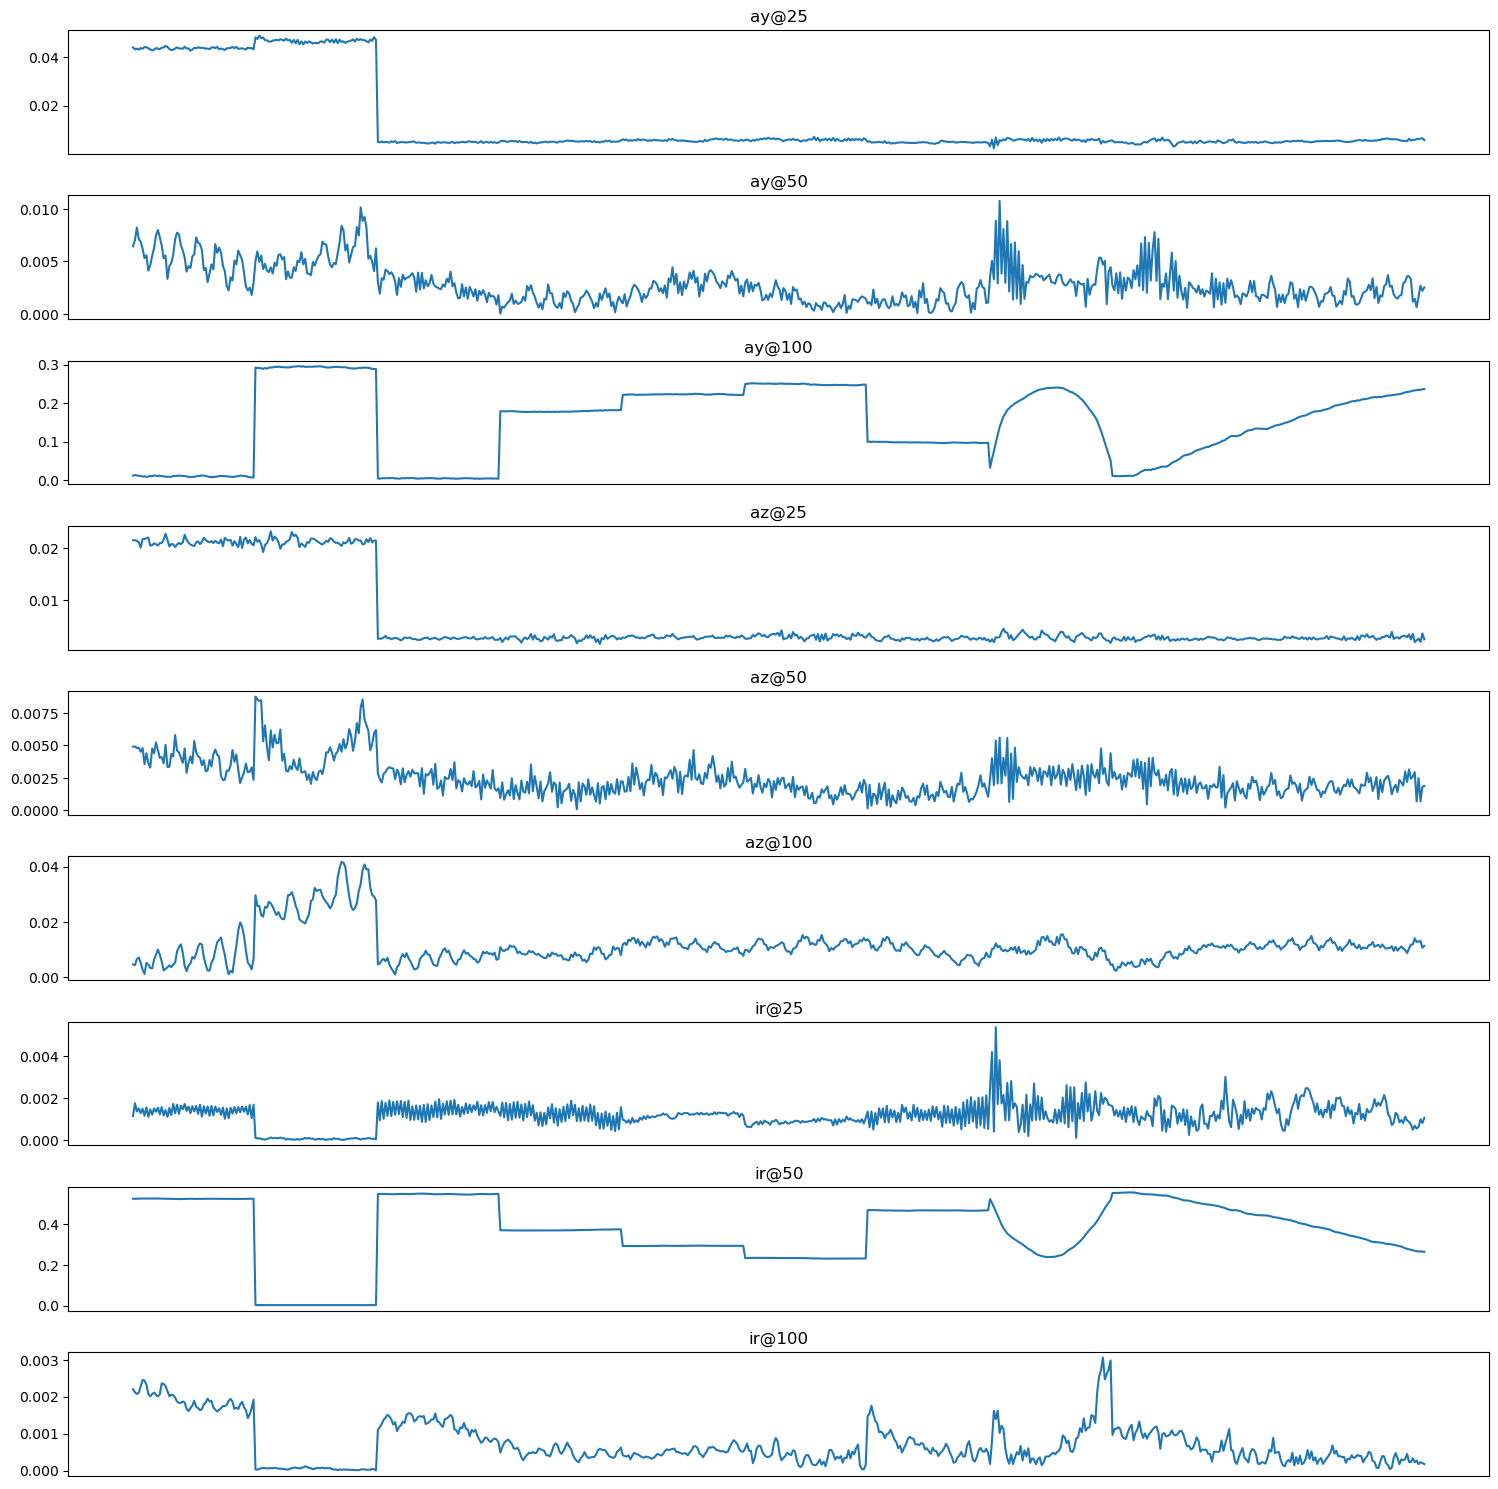

In [3]:
# Extracción de características mediante agregación de armónicos por ventanas


# Parámeetros de enventanado (criterios de agrupamiento de los datos)
N = 1000     # tamaño de la ventana (esto lo elegimos nosotros)
S = 300      # definimos el "salto" entre ventana y ventana 

# frecuencias
f = arange(0,fm,fm/N)

# Variables y condiciones de análisis
variables   = [1,2,3]
ensayos     = [0,1,2,3,4,5,6,7,8]
frecuencias = [25,50,100]

E = []
F = []
for i in ensayos:
    ensayo = datos['z'][0][i]
    Q = ensayo.shape[0]
    for k in range(0,Q-N,S):
        registro = []
        for variable in variables:
            v = ensayo[k:k+N,variable]
            V = abs(fft(v))
            for frecuencia in frecuencias:
                idx = where((f>frecuencia-5)&(f<frecuencia+5))
                registro.append(sqrt(sum(2*V[idx]**2))/N)
        F.append(registro)
        E.append(i)

# componemos F como numpy array
F = array(F)
E = array(E)
# recorremos (variable, frecuencia) de la misma forma para generar las características
etiq_car = []
for variable in variables:
    for frecuencia in frecuencias:
        etiq_car.append(etiq[variable]+'@'+'%.0f'%frecuencia)

# dibujamos las 9 características (3 vars x 3 frecs)
figure(figsize=(15,15))
for i in ensayos:
    subplot(9,1,i+1)
    plot(F[:,i])
    title(etiq_car[i])
    xticks([])
tight_layout()

In [4]:
# seleccionamos las 5 características que nos interesan 
idx_vars = [0,2,3,5,7] 

# creamos X con esas 5 características y lo ponemos en formato no-excel (cada fila una característica)
X = F[:,idx_vars];

# obtenemos las etiquetas para las 5 características
etiq_X = [etiq_car[i] for i in idx_vars]

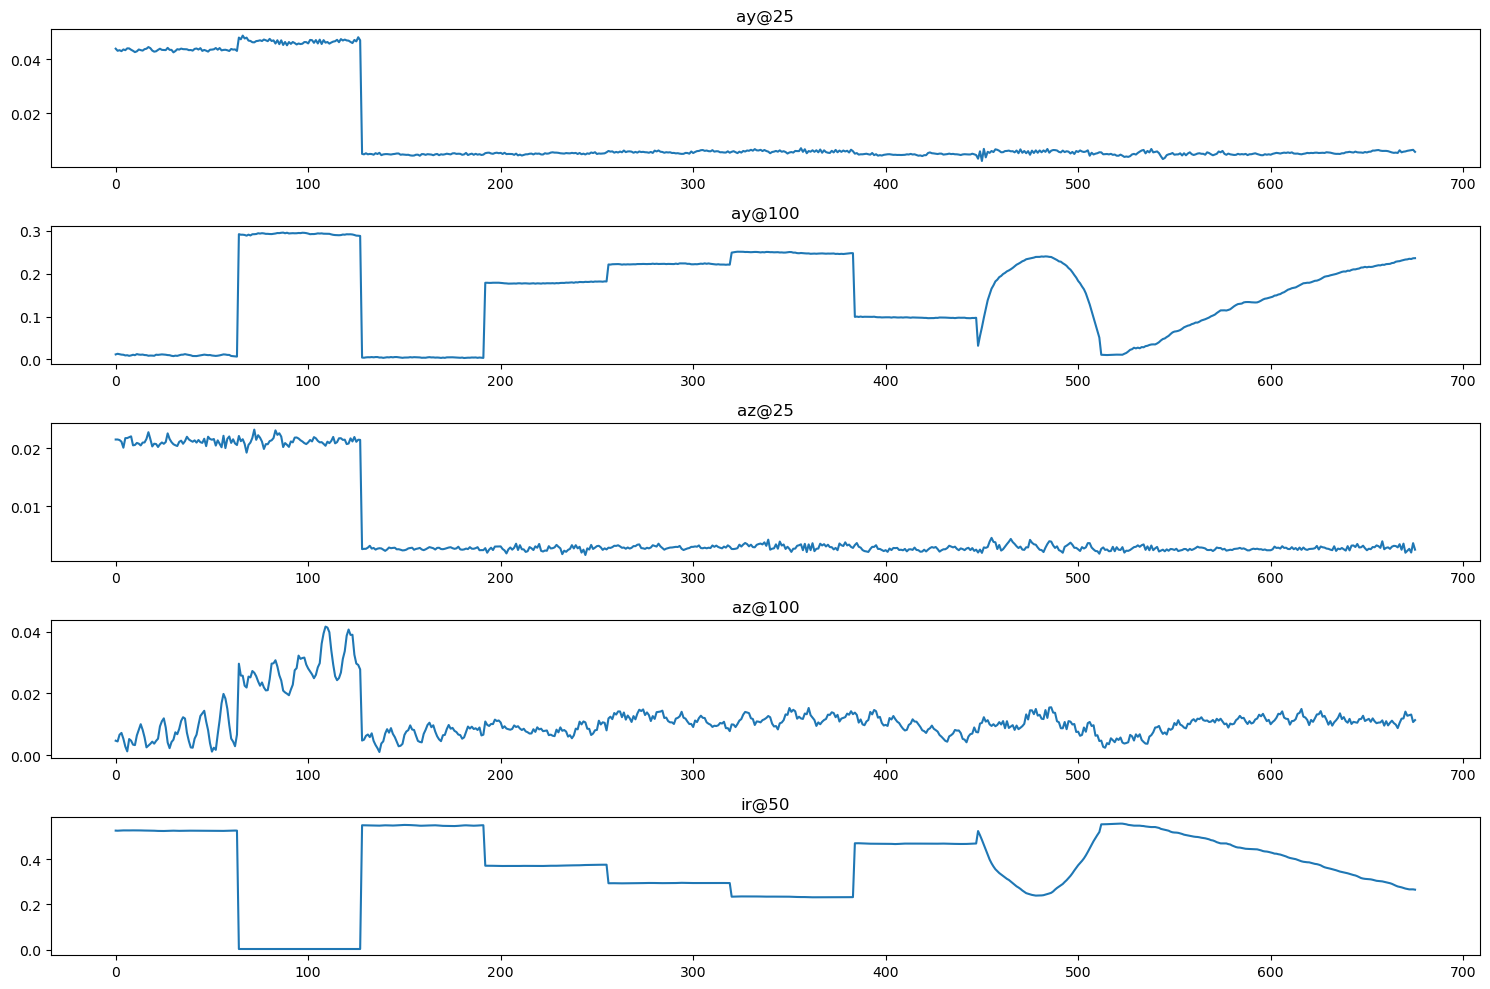

In [5]:
# dibujamos las 5 características obtenidas
figure(figsize=(15,10));
clf();

for i in range(5):
    subplot(5,1,i+1)
    plot(X[:,i])
    title(etiq_X[i])

tight_layout()


### Normalización de los datos

In [6]:
# NORMALIZACIÓN DE LOS DATOS
from sklearn.preprocessing import MinMaxScaler

# definimos un objeto "scaler" de tipo min-max (limita al rango 0, 1)
scale = MinMaxScaler()

# calculamos la transformación ("fit") y la aplicamos ("transform")
# todo en uno ...
Xn = scale.fit_transform(X)

### Reducción de la dimensionalidad
####  Proyección PCA

In [7]:
# realizamos la proyección con t-SNE (técnica de manifold learning, más avanzada que PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pr  = pca.fit_transform(Xn)

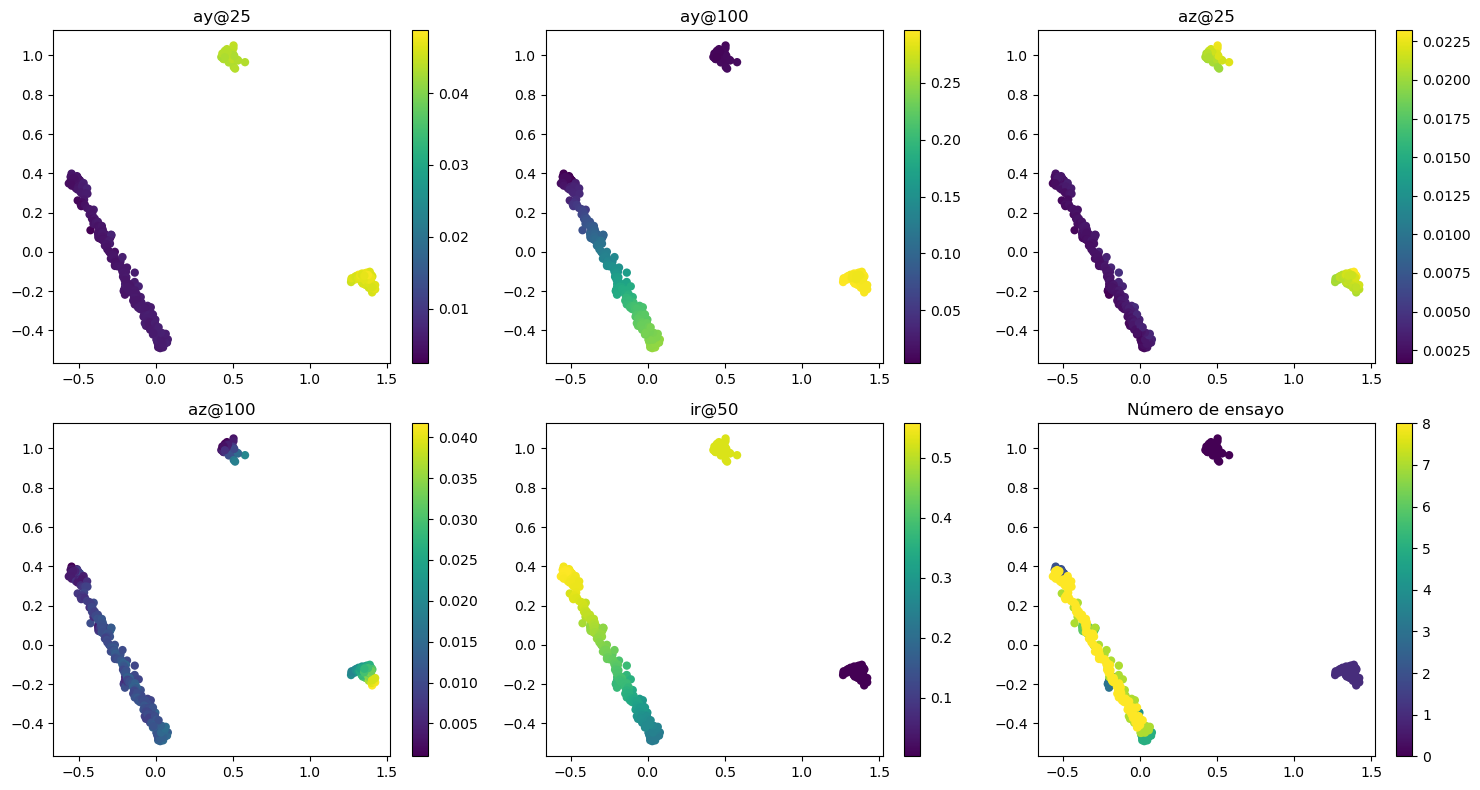

In [8]:
# la visualización de los resultados se puede hacer exactamente igual que con PCA
figure(figsize=(15,8))
for i in range(5):
    subplot(2,3,i+1)
    # scatter(pr[:,0],pr[:,1],c=X[i,:],linewidths=0)
    scatter(pr[:,0],pr[:,1],c=X[:,i],linewidths=0)
    title(etiq_X[i])
    colorbar()

subplot(2,3,6)
scatter(pr[:,0],pr[:,1],c=E,linewidths=0)
title(u'Número de ensayo')
colorbar()
tight_layout()

#### Proyección t-SNE

In [9]:
# realizamos la proyección con t-SNE (técnica de manifold learning, más avanzada que PCA)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=100, method='exact')

pr = tsne.fit_transform(Xn)

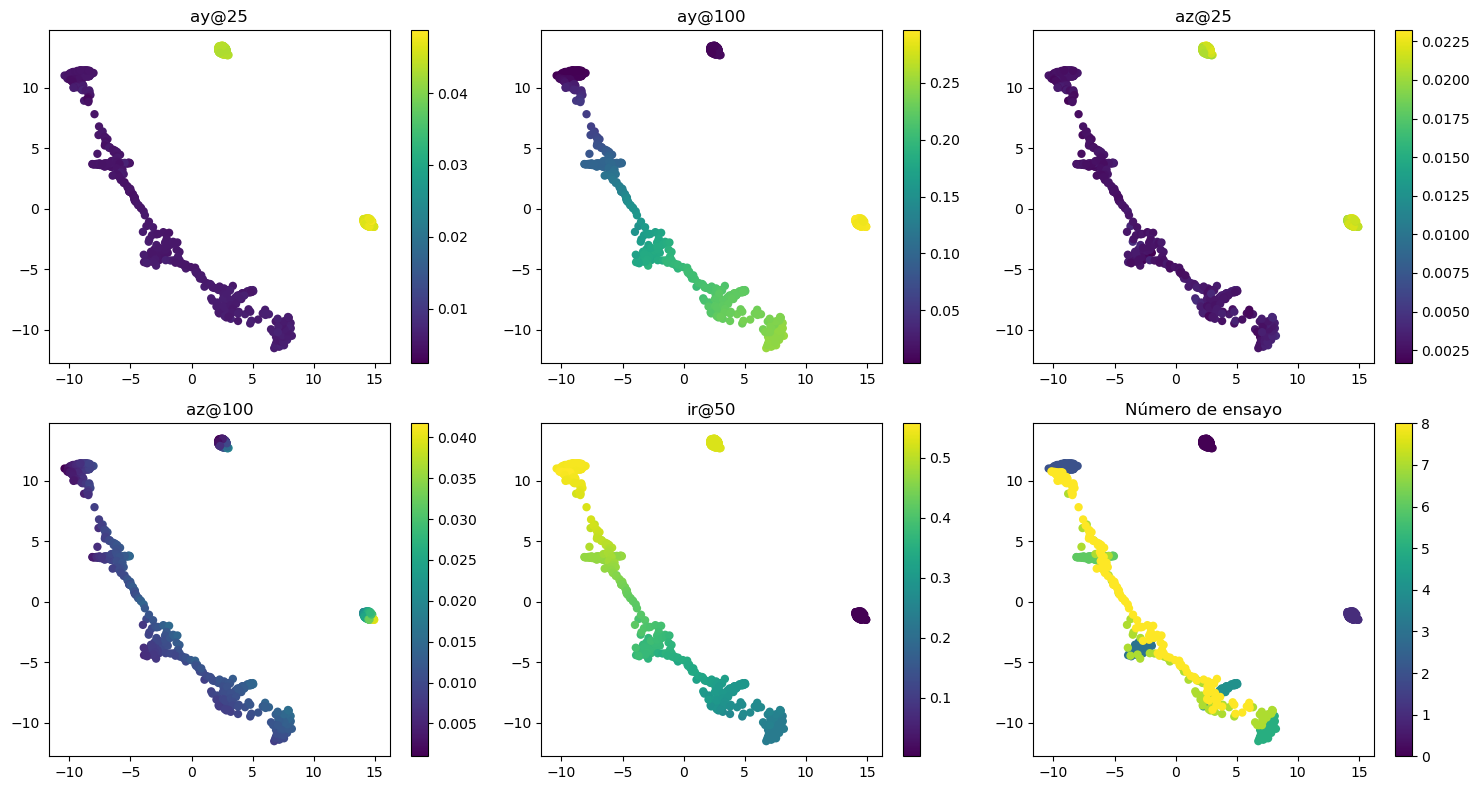

In [10]:
# la visualización de los resultados se puede hacer exactamente igual que con PCA
figure(figsize=(15,8))
for i in range(5):
    subplot(2,3,i+1)
    # scatter(pr[:,0],pr[:,1],c=X[i,:],linewidths=0)
    scatter(pr[:,0],pr[:,1],c=X[:,i],linewidths=0)
    title(etiq_X[i])
    colorbar()

subplot(2,3,6)
scatter(pr[:,0],pr[:,1],c=E,linewidths=0)
title(u'Número de ensayo')
colorbar()
tight_layout()

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span property="dct:title">dataicann excar + pca + tsne</span> by <a href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.